In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


After importing the required libraries, let's load the dataset and get rid of data we don't want (those columns are mostly filled with NULLS).

In [22]:
df = pd.read_csv('data/billionaires_statistics_dataset.csv')
df.drop(['title', 'state', 'residenceStateRegion', 'organization'], axis=1, inplace=True)
df['gdp_country'] = df['gdp_country'].replace('[$,]', '', regex=True).astype(float)


## 1. Box plots and violin plots

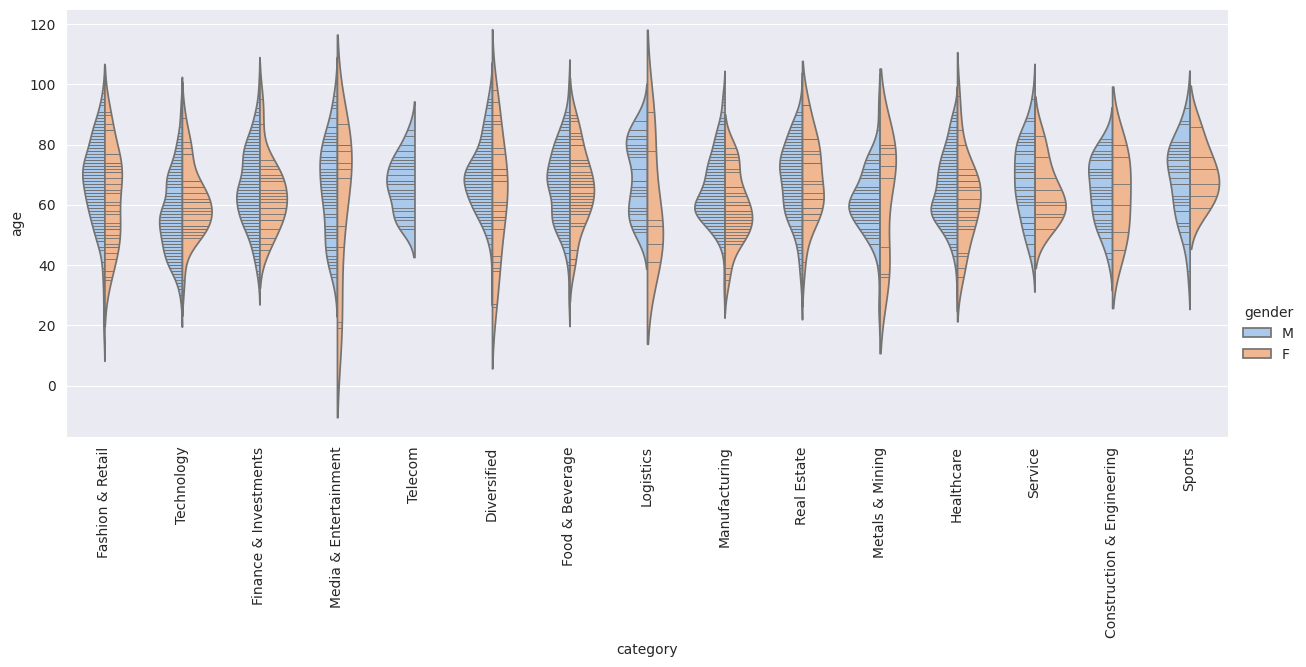

In [23]:
# We get rid of these categories because the plot gets junky and their behaviour is not out of ordinary.
df_filtered = df.query("category not in ['Gambling & Casinos', 'Energy', 'Automotive']")
sns.catplot(data=df_filtered, x='category', y='age', kind='violin', hue='gender', inner="stick", aspect=2.5, split=True, palette='pastel')

plt.xticks(rotation=90)
plt.show()

As we can see from the violin plot above, distribution of age with respect to the category has its quirks. Namely, we can see that in most cases the range is wider for women - especially in "media & entertainment" category - I suppose it is easier for a female musician or actress to become a billionaire. Telecom is an odd case, because we have no female billionaires in this industry in our dataset. Other than that, the distribution of age values is resembling a normal distribution, with except of "Logistics", but it is probably because there is too few records for the Gaussian pattern to form. *We have to account for the kernel density estimator, which smoothes out the plot - to the point where some billionaire supposedly have below 0 years. We know it's not true, as I will show with the box plot below.*

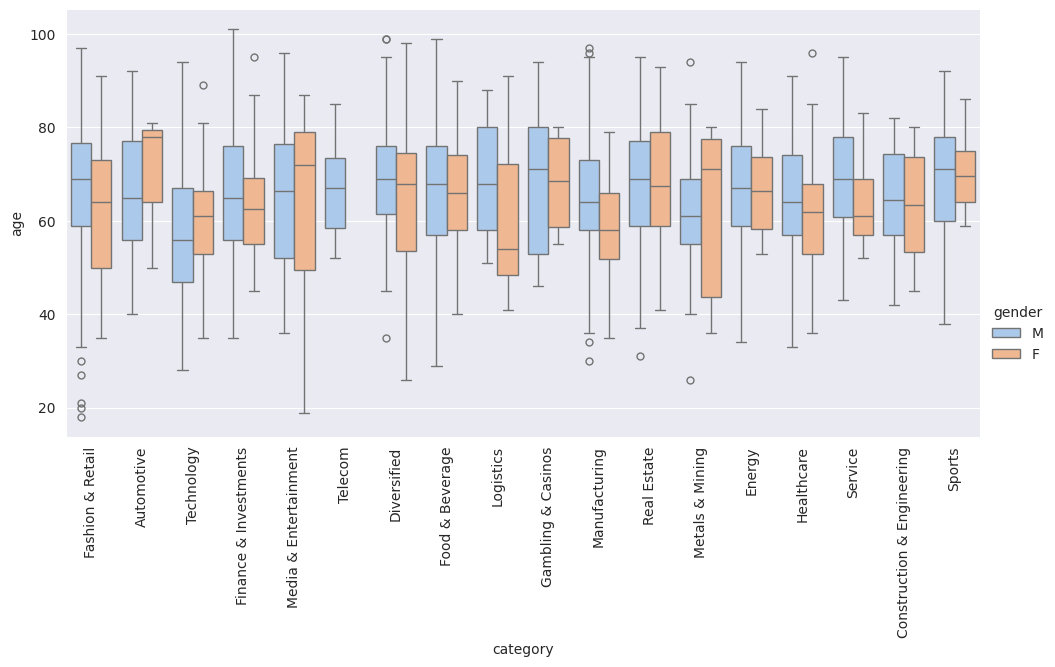

In [24]:
sns.catplot(data=df, x='category', y='age', kind='box', aspect=2, hue='gender', palette='pastel')

plt.xticks(rotation=90)
plt.show()

We can see that in most categories the whiskers are fairly long, which suggests that . We can see that the median is higher for men in almost every category, which pairs up well with the fact that most of woman billionaires are not self-made - I might assume they are younger wifes of deceased billionaires that inherited the wealth.

Below, we can see that the population is condensed close to the lower bound (a few billions) and has many outliers. The female population is more dispersed overall, and they are spaced out more evenly.

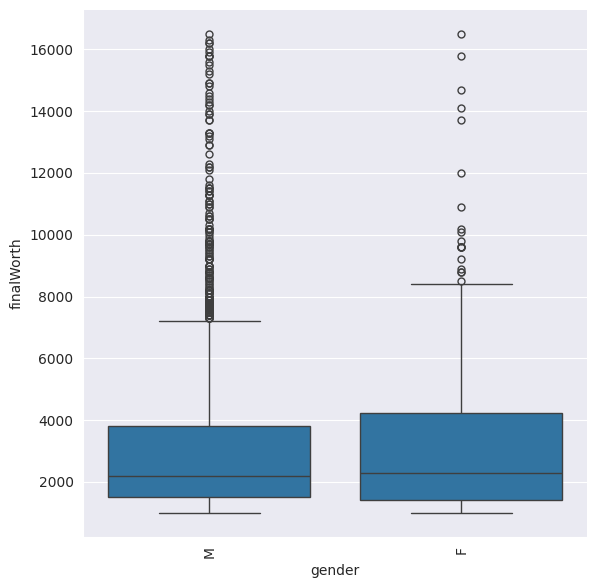

In [25]:
df_filtered = df.query('rank > 100') # We skip the first 100 rank because they are a massive outliers and make the plot unreadable
sns.catplot(data=df_filtered, x='gender', y='finalWorth', kind='box', height=6)
plt.xticks(rotation=90)
plt.show()

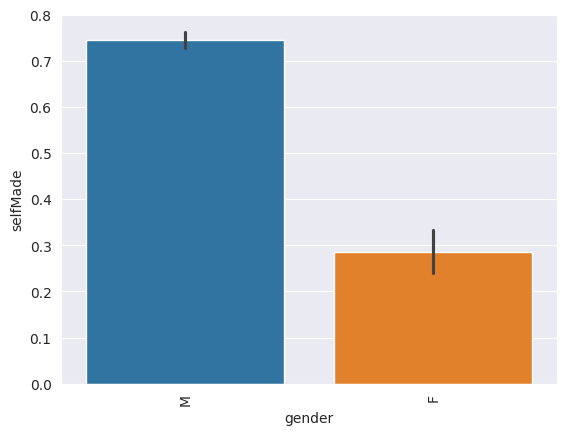

In [26]:
sns.barplot(data=df, x='gender', y='selfMade', hue='gender')
plt.xticks(rotation=90)
plt.show()

We can also see that above 70% of men are self-made billionaires, while it's only slightly below 30% for women.

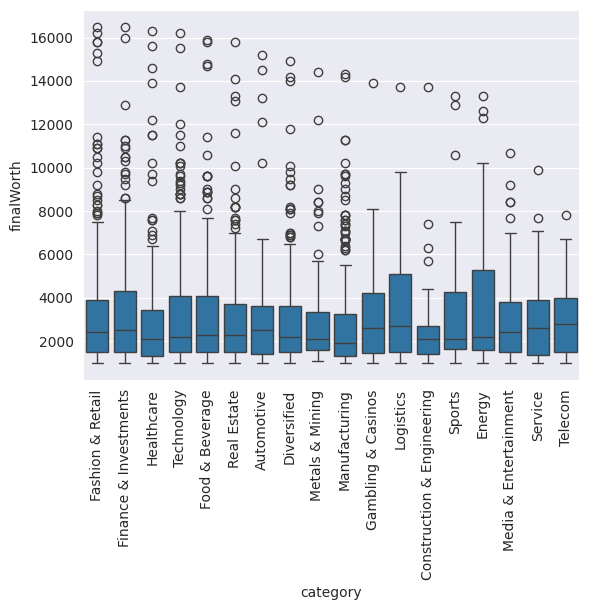

In [27]:
sns.boxplot(data=df.query('rank > 100'), x='category', y='finalWorth')
plt.xticks(rotation=90)
plt.show()

We can see that even if we get rid of the biggest outliers, there still is many, so the outside quantiles are very dispersed in most categories. The categories with less outliers are also the categories with less specimen overall.

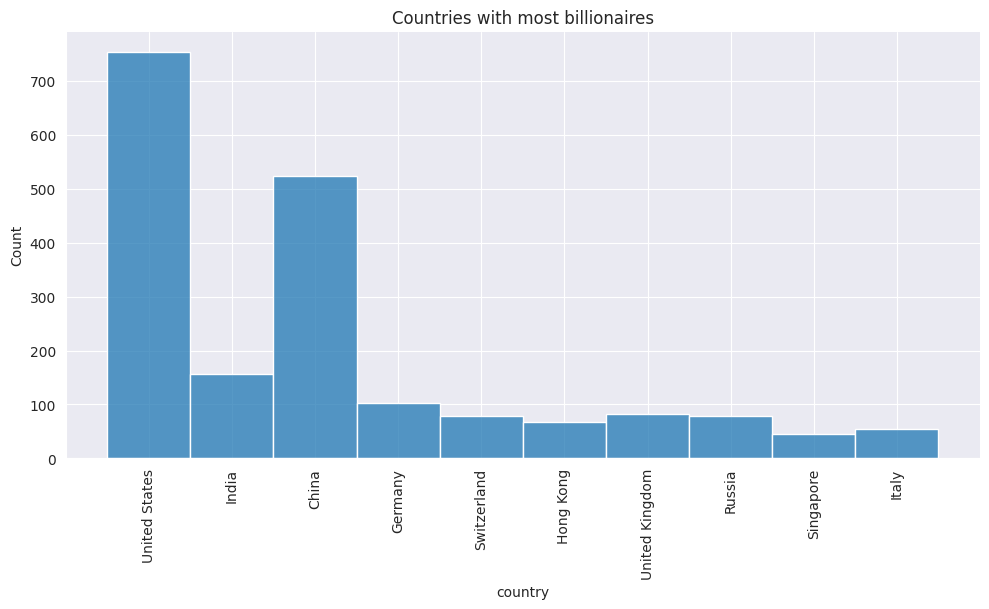

In [28]:
top10_countries = df['country'].value_counts().sort_values(ascending=False).nlargest(10).index
_df = df[df['country'].isin(top10_countries)]
sns.displot(_df, x='country', aspect=2)
plt.xticks(rotation=90)
plt.title("Countries with most billionaires")
plt.show()

## 2. Distributions

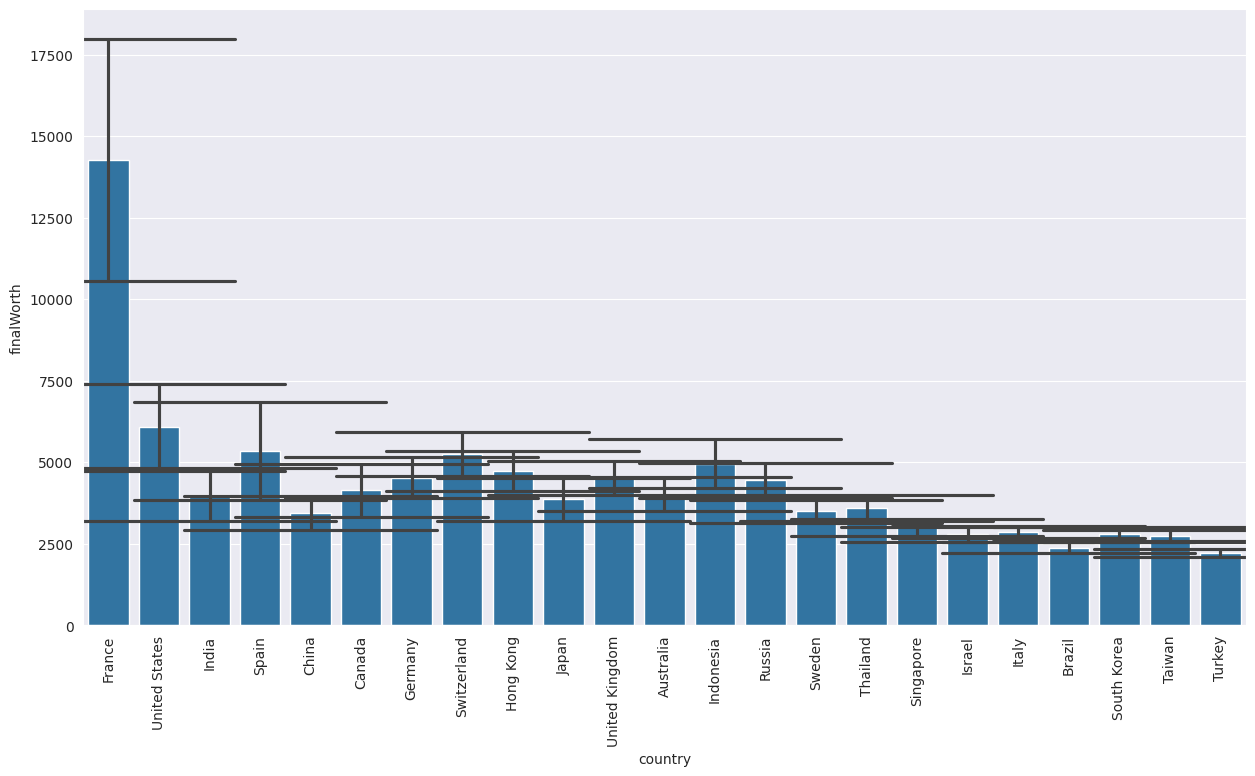

In [29]:
_df = df.groupby('country').filter(lambda x: len(x) > 20)

plt.figure(figsize=(15,8))
sns.barplot(data=_df, x='country', y='finalWorth', estimator='mean', errorbar=("sd", 0.1), capsize=5)

plt.xticks(rotation=90)
plt.show()

As we can see, standard deviation is huge in most of these (especially in France, if even 0.1 of std_deviation is such a big part of the actual value.

Let's see distribution of probability of a finalWorth value at a given age, conditioned by gender.

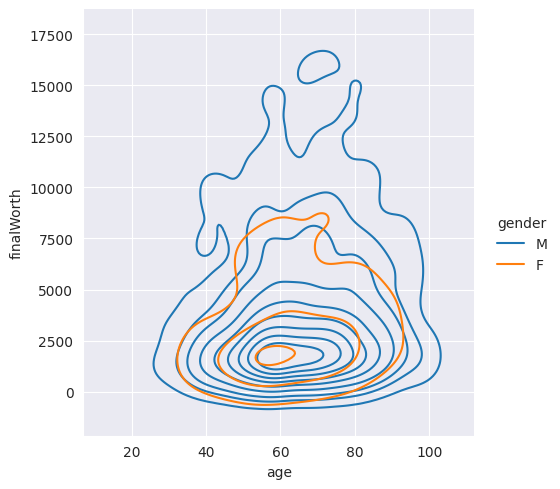

In [30]:
sns.displot(_df.query('rank > 100'), x='age', y='finalWorth', hue='gender', kind='kde')

There is less lines for women, as the sample is small and distributed more uniformly. On the top we can see a weird squiggle, which shows that there's a window with a small probability - there's a window between 10 and 15 billion which is not probable at age of ~65. This is probably due to the fact that over 10 billion the values are in general more dispersed.

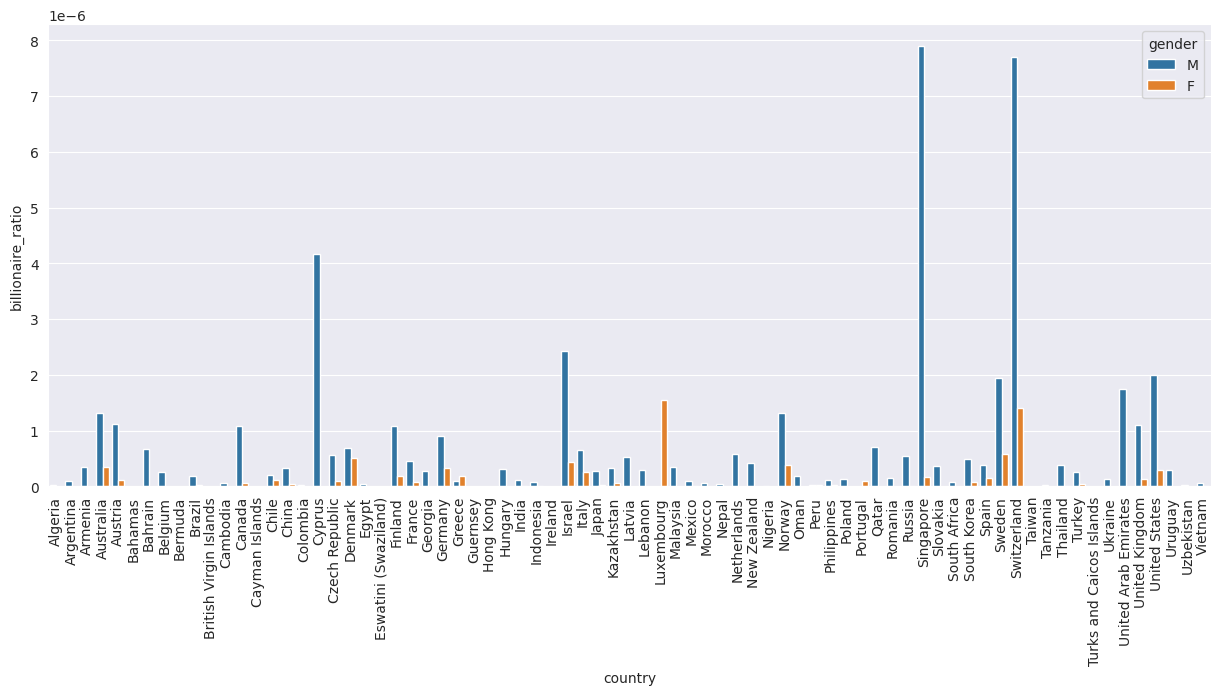

In [31]:
df_counts = df.groupby(['country', 'gender']).size().reset_index(name='billionaire_count')
df_population = df.groupby('country')['population_country'].first().reset_index()

df_ratio = df_counts.merge(df_population, on='country')

df_ratio['billionaire_ratio'] = df_ratio['billionaire_count'] / df_ratio['population_country']

df_ratio = df_ratio[~df_ratio['country'].isin(['Monaco', 'Liechtenstein', 'Andorra'])]

plt.figure(figsize=(15, 6))
sns.barplot(data=df_ratio, x='country', y='billionaire_ratio', hue='gender')

plt.xticks(rotation=90)
plt.show()

Why delete Monaco and Liechtenstein? Well, Monaco's billionaires-to-population ratio is over 16 times bigger than with Liechtenstein, which already is a lot bigger than in all the other countries.

In [32]:
monaco_billionaires = df[df['country'] == 'Monaco'].shape[0]
monaco_population = df[df['country'] == 'Monaco']['population_country'].iloc[0]
monaco_btp_ratio = monaco_billionaires / monaco_population

liechtenstein_billionaires = df[df['country'] == 'Liechtenstein'].shape[0]
liechtenstein_population = df[df['country'] == 'Liechtenstein']['population_country'].iloc[0]
liechtenstein_btp_ratio = liechtenstein_billionaires / liechtenstein_population

singapore_billionaires = df[df['country'] == 'Singapore'].shape[0]
singapore_population = df[df['country'] == 'Singapore']['population_country'].iloc[0]
singapore_btp_ratio = singapore_billionaires / singapore_population

print(monaco_btp_ratio / liechtenstein_btp_ratio)
print(liechtenstein_btp_ratio / singapore_btp_ratio)

16.587696335078533
3.2612806868876776


It is usually due to their low population, where just 1 billionaire is enough to get the country to skyrocket off the charts in this plot, although this is not the case with Monaco - in addition to its low population, there is also many billionaires. 

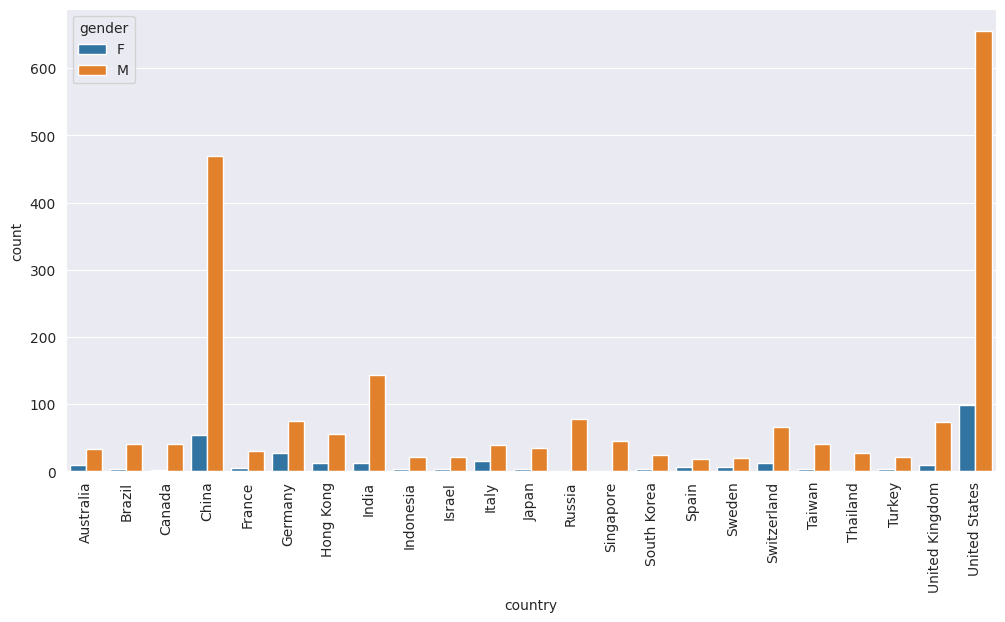

In [33]:
df_counts = _df.groupby(['country', 'gender']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x='country', y='count', hue='gender')

plt.xticks(rotation=90)
plt.show()

## 3. Data correlation heatmap


<Axes: >

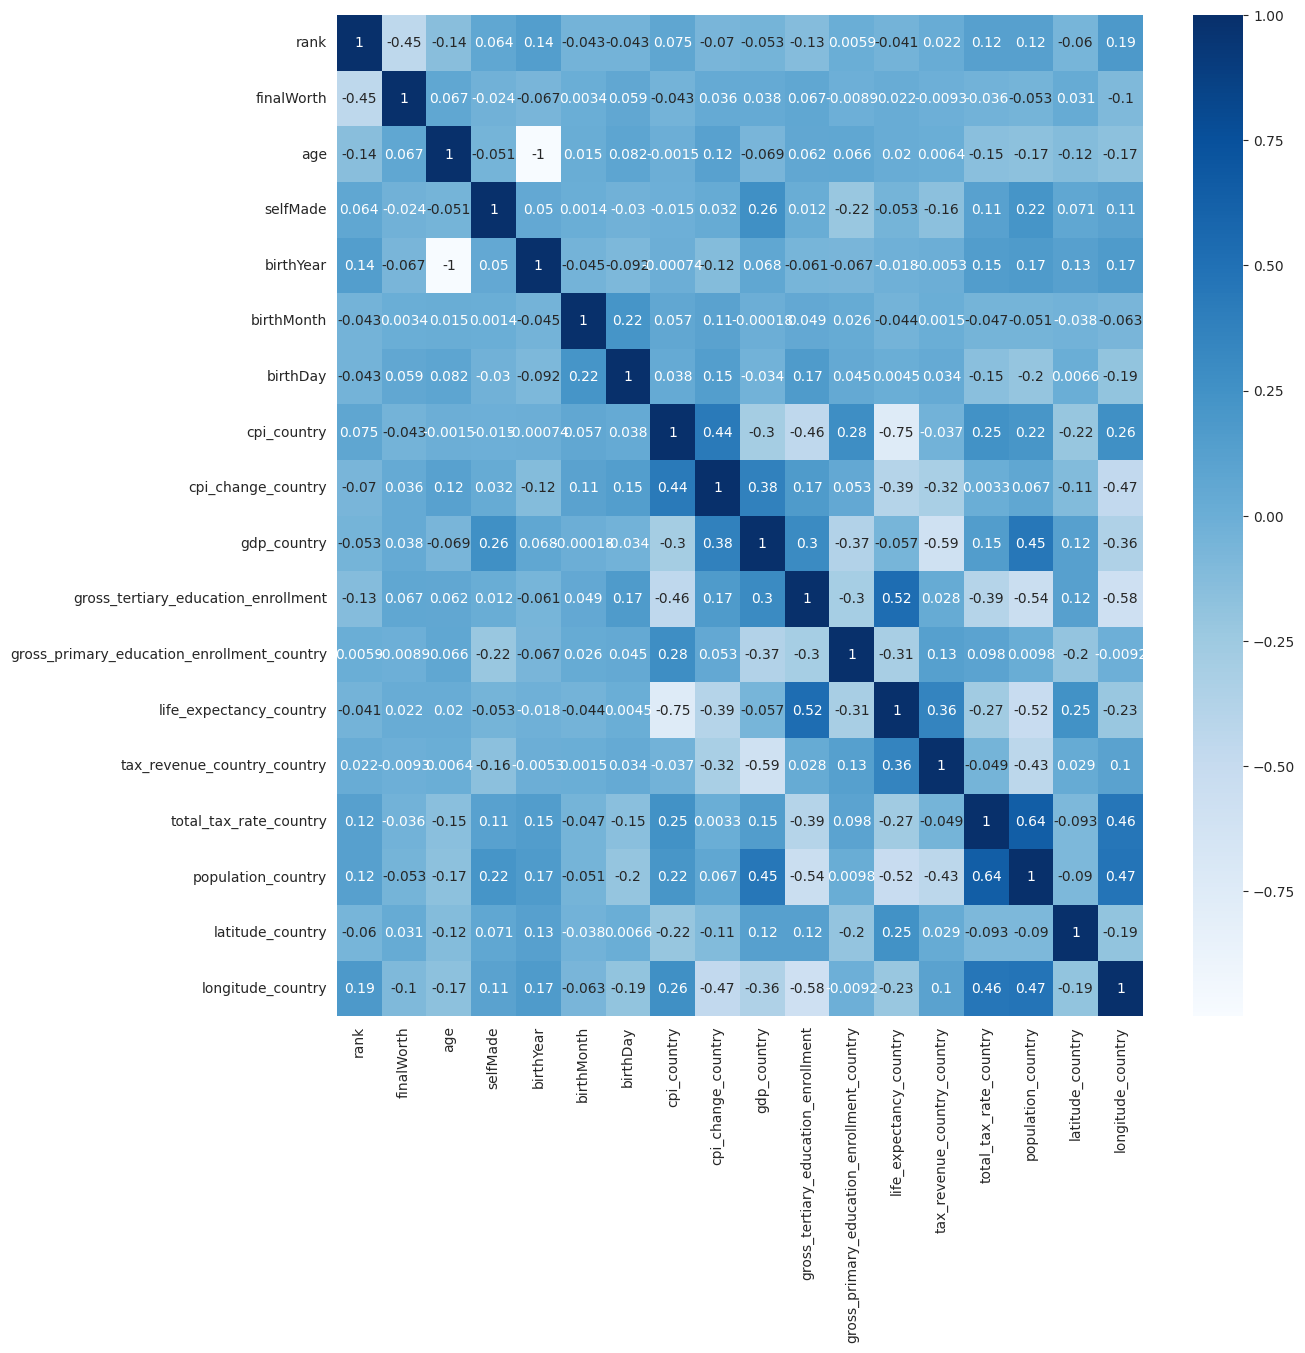

In [34]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(13, 13))
sns.heatmap(corr, annot=True, cmap='Blues')

From the heatmap above we can see that there is not many strongly correlated value. Unfortunately the finalWorth column does not correlate with any of other values, which may imply that answering to the question: "will a specimen with prospect of being a billionaire become extraordinarily rich even in comparison to other billionaires?" is a hard task with just this dataset. Furthermore, it seems that either the sample of the population is too small or it just depends on one's luck.

There is a slight correlation between finalWorth and birthYear, which just means older people are richer - most billionaires accumulate money throughout their lifes, so it makes sense. Now, series with the strongest correlation with each other are related to GDP, CPI, tax_rate and population.

CPI, Consumer Price Index measures the monthly change in prices paid by consumers. It has a strong inverse correlation with life expectancy, as does the gross tertiary education enrollment (whether people go to college or equivalent)

## Conclusion
Overall, only apparent meaningful conclusion may be drawn from billionaire_to_population ratio in each country and the mean finalWorth of billionaires in those countries. Other than that, single variables do not seem to correlate in any strong way to finalWorth, but maybe we should instead correlate them to the fact of someone being a billionaire at all. Data on taxes, GDP, CPI and life expectancy can be further explored as the correlations there are stronger.
We've also seen that women are mostly billionaires by external sources, the 2/3 of billionaires is self-made and the man/woman ratio in billionaires is about 6/1. 
The majority of billionaires is just around 1 billion in worth, with many widely spread outliers - which makes sense, as the billionaire is in the upper percentile of distribution of wealth in society, where the spread gets widest.
